# 基于线性回归预测波士顿房价

## 一、导入工具包

In [1]:
# 基础库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline
pd.set_option('display.max_columns', None)

# 可视化库
import seaborn as sns
from scipy.stats import skew # 偏度计算

# 模型库
from sklearn.linear_model import LinearRegression

# 结果评估库
from sklearn.metrics import mean_squared_error,r2_score

## 二、数据加载

In [2]:
train = pd.read_csv('../data/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Id列无意义，删掉

In [3]:
train.drop(['Id'], axis=1, inplace=True)

### 特征重命名

In [4]:
train = train.rename({
    'MSSubClass':'住所类型',
    'MSZoning':'区域分类',
    'LotFrontage':'房子同街道之间距离',
    'LotArea':'建筑面积',
    'Street':'主路路面类型',
    'Alley':'辅路路面类型',
    'LotShape':'房屋外形',
    'LandContour':'平整度',
    'Utilities':'配套公用设施类型',
    'LotConfig':'地段',
    'LandSlope':'土地坡度',
    'Neighborhood':'房屋位置',
    'Condition1':'附近交通情况1',
    'Condition2':'附近交通情况2',
    'BldgType':'住宅类型',
    'HouseStyle':'房屋层数',
    'OverallQual':'材料与质量',
    'OverallCond':'整体状况评级',
    'YearBuilt':'建造年份',
    'YearRemodAdd':'翻修年份',
    'RoofStyle':'屋顶类型',
    'RoofMatl':'屋顶材料',
    'Exterior1st':'外立面材料',
    'Exterior2nd':'外立面材料2',
    'MasVnrType':'装饰石材类型',
    'MasVnrArea':'装饰石材面积',
    'ExterQual':'外立面材料质量',
    'ExterCond':'外立面材料外观情况',
    'Foundation':'房屋结构类型',
    'BsmtQual':'地下室高度',
    'BsmtCond':'地下室总体情况',
    'BsmtExposure':'地下室出口或花园墙面',
    'BsmtFinType1':'地下室竣工等级1',
    'BsmtFinSF1':'类型1完工面积',
    'BsmtFinType2':'地下室竣工等级2',
    'BsmtFinSF2':'类型2完工面积',
    'BsmtUnfSF':'地下室区域未完工面积',
    'TotalBsmtSF':'地下室总体面积',
    'Heating':'采暖类型',
    'HeatingQC':'采暖质量和条件',
    'CentralAir':'中央空调系统',
    'Electrical':'电力系统',
    '1stFlrSF':'一层面积',
    '2ndFlrSF':'二层面积',
    'LowQualFinSF':'低质量完工面积',
    'GrLivArea':'地面以上部分起居面积',
    'BsmtFullBath':'地下室全浴室数量',
    'BsmtHalfBath':'地下室半浴室数量',
    'FullBath':'全浴室数量',
    'HalfBath':'半浴室数量',
    'BedroomAbvGr':'地面以上卧室数量',
    'KitchenAbvGr':'厨房数量',
    'KitchenQual':'厨房质量',
    'TotRmsAbvGrd':'总房间数',
    'Functional':'功能性评级',
    'Fireplaces':'壁炉数量',
    'FireplaceQu':'壁炉质量',
    'GarageType':'车库位置',
    'GarageYrBlt':'车库建造时间',
    'GarageFinish':'车库内部装修',
    'GarageCars':'车库容量',
    'GarageArea':'车库面积',
    'GarageQual':'车库质量',
    'GarageCond':'车库状况',
    'PavedDrive':'铺面车道',
    'WoodDeckSF':'实木地板面积',
    'OpenPorchSF':'开放式门廊面积',
    'EnclosedPorch':'封闭式门廊面积',
    '3SsnPorch':'三季门廊面积',
    'ScreenPorch':'纱窗门廊面积',
    'PoolArea':'游泳池面积',
    'PoolQC':'游泳池质量',
    'Fence':'围栏质量',
    'MiscFeature':'其它特性',
    'MiscVal':'杂项部分价值',
    'MoSold':'卖出月份',
    'YrSold':'卖出年份',
    'SaleType':'出售类型',
    'SaleCondition':'出售条件',
    'SalePrice':'出售价格'
},axis=1)

### 切分特征和标签

In [5]:
# 切分特征和标签
feature = train.iloc[:,:-1]
label = train.iloc[:,-1]

## 三、数据预处理

### 3.1 异常值处理

#### 区分数值型特征和类别型特征

In [6]:
feature_cols = feature.columns.tolist()
numerical_cols = []
categorical_cols = []
for col in feature_cols:
    if train[col].dtype != 'object':
        numerical_cols.append(col)
    else:
        categorical_cols.append(col)

#### 数值型特征箱型图绘制

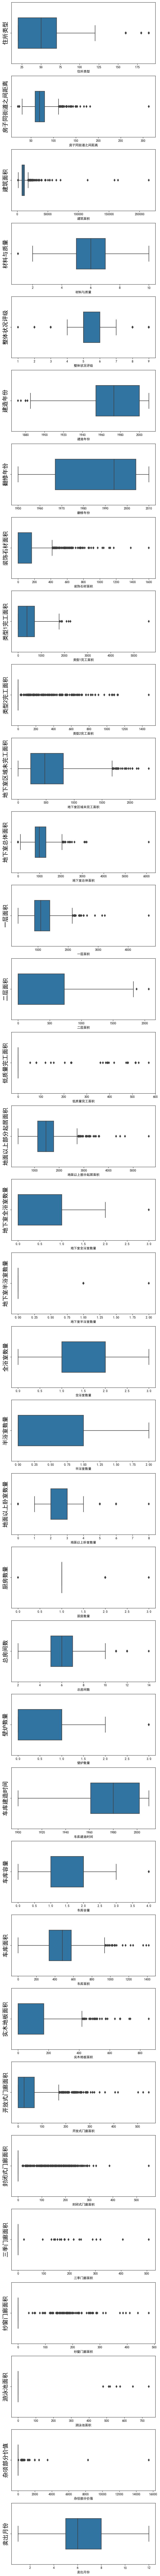

In [7]:
fig = plt.figure(figsize=(8,150),dpi=120)
for i in range(len(numerical_cols)-1):
    plt.subplot(36, 1, i+1)
    sns.boxplot(train[numerical_cols[i]], orient='h', width=0.5)
    plt.ylabel(numerical_cols[i], fontsize=18)
plt.show()

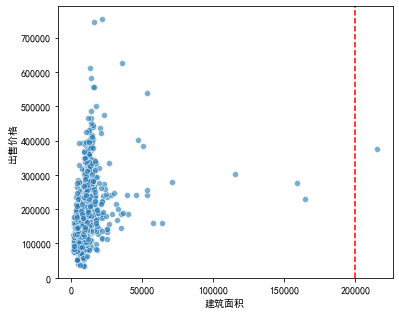

In [8]:
#建筑面积与房屋售价关系
fig = plt.figure(figsize=(6,5))
plt.axvline(x=200000, color='r', linestyle='--')
sns.scatterplot(x='建筑面积',y='出售价格',data=train, alpha=0.6)

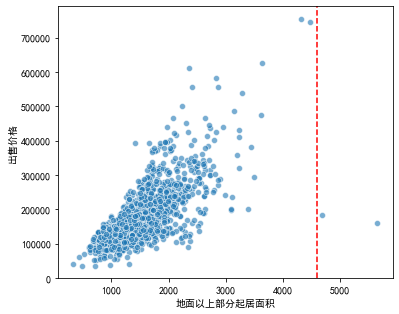

In [9]:
#地面上居住面积与房屋售价关系
fig = plt.figure(figsize=(6,5))
plt.axvline(x=4600, color='r', linestyle='--')
sns.scatterplot(x='地面以上部分起居面积',y='出售价格',data=train, alpha=0.6)

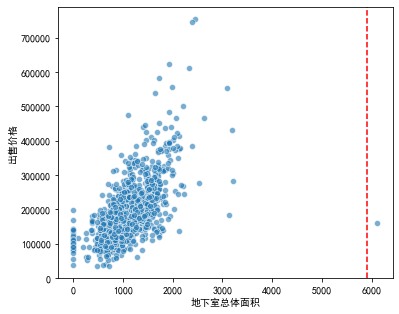

In [10]:
#地下室总面积与房屋售价关系
fig = plt.figure(figsize=(6,5))
plt.axvline(x=5900, color='r', linestyle='--')
sns.scatterplot(x='地下室总体面积',y='出售价格',data=train, alpha=0.6)

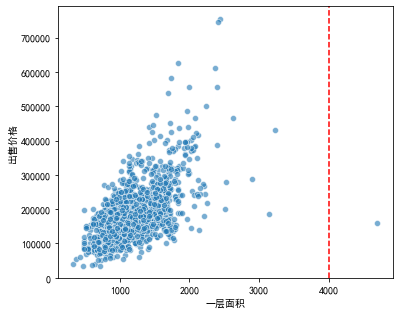

In [11]:
#第一层面积与房屋售价关系
fig = plt.figure(figsize=(6,5))
plt.axvline(x=4000, color='r', linestyle='--')
sns.scatterplot(x='一层面积',y='出售价格',data=train, alpha=0.6)

#### 删除异常值

In [12]:
train = train[train['地面以上部分起居面积'] < 4600]
train = train[train['地下室总体面积'] < 5000]
train = train[train['一层面积'] < 4000]
train.reset_index(drop=True, inplace=True)
train.shape

(1458, 80)

### 3.2 缺失值处理

In [13]:
missingDf = train.isnull().sum().sort_values(ascending=False).reset_index()
missingDf.columns = ['feature', 'missing_num']
missingDf['missing_percentage'] = missingDf['missing_num'] / train.shape[0]
missingDf.head(20)

,feature,missing_num,missing_percentage
0,游泳池质量,1452,0.995885
1,其它特性,1404,0.962963
2,辅路路面类型,1367,0.937586
3,围栏质量,1177,0.807270
4,壁炉质量,690,0.473251
5,房子同街道之间距离,259,0.177641
6,车库位置,81,0.055556
7,车库状况,81,0.055556
8,车库内部装修,81,0.055556
9,车库质量,81,0.055556


In [16]:
#由于类别型变量的许多NA均表示没有此功能，统一填充为"None"
for col in ["游泳池质量","其它特性","辅路路面类型","围栏质量","壁炉质量","装饰石材类型","配套公用设施类型","车库状况","车库质量","车库内部装修","车库位置","地下室高度","地下室总体情况","地下室出口或花园墙面","地下室竣工等级1","地下室竣工等级2","电力系统"]:
    feature[col].fillna("None",inplace=True)

### 3.3 检验因变量是否符合正态分布

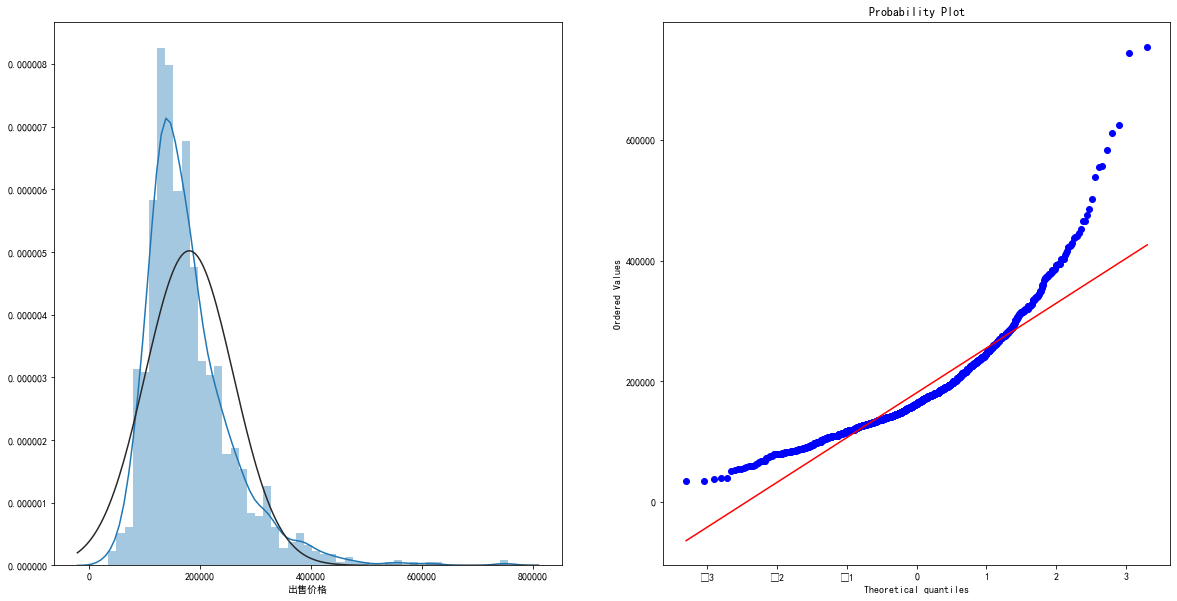

In [24]:
from scipy.stats import norm
from scipy import stats

figure = plt.figure(figsize=(20, 10))

figure.add_subplot(1,2,1)
sns.distplot(train['出售价格'], fit=norm)

figure.add_subplot(1,2,2)
stats.probplot(train['出售价格'], plot=plt)
plt.show()

#### 对因变量取log值

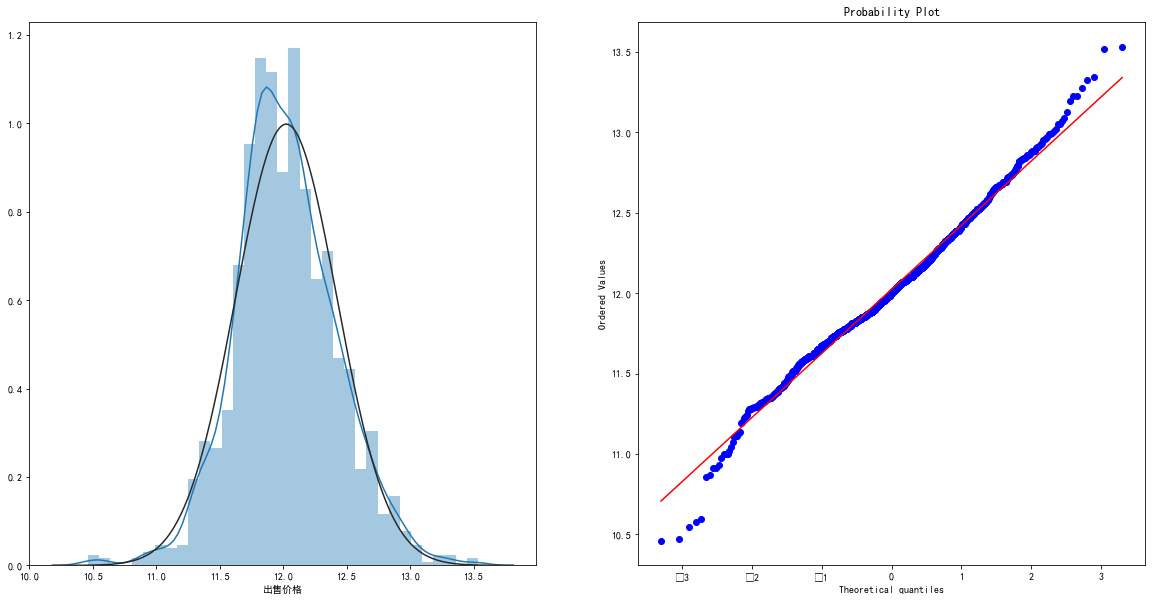

In [25]:
figure = plt.figure(figsize=(20, 10))

figure.add_subplot(1,2,1)
sns.distplot(np.log(train['出售价格']), fit=norm)

figure.add_subplot(1,2,2)
stats.probplot(np.log(train['出售价格']), plot=plt)
plt.show()

## 四、特征工程

## 五、模型训练

#### 切分训练集和测试集


In [28]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest,Ytrain,Ytest = train_test_split(feature,label,test_size=0.3,random_state = 0)

#### 模型训练

In [30]:
model = LinearRegression()
model.fit(Xtrain,Ytrain)
model.predict(Xtest)

ValueError: could not convert string to float: 'RL'